# Notebook A: Mechalis Menton Fitting

### Setup imports

In [1]:
import pandas as pd
from scipy.signal import savgol_filter
from scipy.interpolate import interp1d
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import numpy as np
import sys

source_dir = '../'
sys.path.append(source_dir)

from functions.plot_smoothed_data import plot_smoothed_data
from functions.plot_rates_vs_conc import plot_rates_vs_conc
from functions.plot_rates_vs_conc_fit import plot_rates_vs_conc_fit
from functions.plot_time_courses import plot_time_courses
from functions.get_michaelis_menten_values import get_michaelis_menten_values

plt.rcParams.update({'font.size': 16}) 


### Load phenol data

In [2]:
peroxide_ratio_df = pd.read_csv('../data/phenol_bpa_hrp_to_peroxide_ratio.csv')

peroxide_ratio_df

,time,0.5:1 phe 1,0.5:1 phe 2,0.5:1 phe 3,1:1 phe 1,1:1 phe 2,1:1 phe 3,2:1 phe 1,2:1 phe 2,2:1 phe 3,...,3:1 phe 2,3:1 phe 3,1:1 BPA 1,1:1 BPA 2,1:1 BPA 3,2:1 BPA 1,2:1 BPA 2,2:1 BPA 3,3:1 BPA 1,3:1 BPA 2
0,0,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,...,1.000000,1.000000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
1,1,0.8394,0.8684,1.0109,0.8394,0.8912,0.9130,0.8182,0.7411,0.7429,...,0.920000,0.951087,0.9377,0.8925,0.8639,0.5405,0.7155,0.5353,0.7143,0.6940
2,5,0.9171,0.7947,0.8852,0.6166,0.7461,0.8859,0.5808,0.4213,0.4476,...,0.954286,0.961957,0.8370,0.7679,0.7311,0.1818,0.3684,0.2561,0.4433,0.4557
3,10,0.9223,0.9053,0.8852,0.5648,0.6839,0.6793,0.4798,0.2944,0.3095,...,0.920000,0.956522,0.8297,0.6636,0.6353,0.0860,0.2253,0.1468,0.3186,0.3366
4,20,0.8808,0.8895,0.8689,0.4456,0.5337,0.5815,0.4040,0.1777,0.2048,...,0.902857,0.934783,0.7106,0.6121,0.5378,0.0264,0.1053,0.0691,0.2053,0.2206
5,30,0.9016,0.8895,0.8798,0.5648,0.4974,0.4891,0.3636,0.1574,0.1524,...,0.868571,0.929348,0.6612,0.5779,0.4588,0.0198,0.0625,0.0259,0.1461,0.1643
6,45,0.9016,0.8737,0.8033,0.5803,0.4611,0.6141,0.2828,0.2132,0.1381,...,0.880000,0.907609,0.6026,0.5312,0.3983,0.0094,0.0362,0.0216,0.1051,0.1224
7,60,0.8549,0.8737,0.9508,0.6529,0.4197,0.5924,0.3030,0.1472,0.1333,...,0.840000,0.902174,0.6081,0.4751,0.3496,0.0109,0.0247,0.0173,0.0788,0.0918
8,90,0.8238,0.8474,0.9071,0.4870,0.4922,0.5924,0.2576,0.1218,0.2048,...,0.868571,0.885870,0.5458,0.4159,0.2958,0.0096,0.0164,0.0092,0.0509,0.0821


### Create a dataframe with smoothed values

In [3]:
# Create new time points from 0 to 90 minutes (1-minute intervals)
new_time_points = np.arange(0, 91, 1)

# Create an empty DataFrame for the new interpolated and smoothed data
interpolated_df = pd.DataFrame({'time': new_time_points})

# Produce a linear interpolation of each column
for col in peroxide_ratio_df.columns[1:]:

    # first create linear interpolations between measured time points
    interpolation_func = interp1d(
        peroxide_ratio_df['time'], 
        peroxide_ratio_df[col], 
        kind='linear', 
        fill_value="extrapolate"
    )
    interpolated_values = interpolation_func(new_time_points)
    interpolated_df[col] = interpolated_values

# Apply the Savitzky-Golay filter to smooth the interpolated data
smoothed_df = pd.DataFrame({'time': new_time_points})

# Define the window length and polynomial order
window_length = 15  # Should be odd and larger for smoother curves
poly_order = 3

for col in interpolated_df.columns[1:]:
    first_val = interpolated_df[col].values[0]
    # smoothed_values = savgol_filter(interpolated_df[col], window_length, poly_order, mode='constant', cval=first_val)
    smoothed_values = savgol_filter(interpolated_df[col], window_length, poly_order)
    smoothed_df[f'{col} smoothed'] = smoothed_values

smoothed_df.head(10)

,time,0.5:1 phe 1 smoothed,0.5:1 phe 2 smoothed,0.5:1 phe 3 smoothed,1:1 phe 1 smoothed,1:1 phe 2 smoothed,1:1 phe 3 smoothed,2:1 phe 1 smoothed,2:1 phe 2 smoothed,2:1 phe 3 smoothed,...,3:1 phe 2 smoothed,3:1 phe 3 smoothed,1:1 BPA 1 smoothed,1:1 BPA 2 smoothed,1:1 BPA 3 smoothed,2:1 BPA 1 smoothed,2:1 BPA 2 smoothed,2:1 BPA 3 smoothed,3:1 BPA 1 smoothed,3:1 BPA 2 smoothed
0,0,0.936296,0.977614,1.023275,0.979198,0.983581,0.959989,0.970015,0.955943,0.951674,...,0.965900,0.982116,0.996026,0.976254,0.969392,0.898251,0.950523,0.883307,0.939738,0.928507
1,1,0.909320,0.902783,0.989959,0.871283,0.914350,0.950444,0.858503,0.800130,0.805094,...,0.955892,0.970930,0.947151,0.920365,0.900706,0.668313,0.781156,0.676147,0.789782,0.781169
2,2,0.892837,0.851494,0.962070,0.784933,0.858113,0.934218,0.766613,0.672818,0.684635,...,0.948355,0.963115,0.909220,0.871846,0.843393,0.487286,0.642508,0.513589,0.668310,0.662885
3,3,0.885127,0.820488,0.939146,0.717612,0.813277,0.912459,0.692273,0.570889,0.587486,...,0.942889,0.958150,0.880776,0.830075,0.796206,0.349403,0.531247,0.390248,0.572089,0.570249
4,4,0.884472,0.806503,0.920726,0.666786,0.778250,0.886316,0.633413,0.491228,0.510837,...,0.939095,0.955515,0.860361,0.794431,0.757894,0.248896,0.444042,0.300738,0.497884,0.499853
5,5,0.889153,0.806281,0.906350,0.629917,0.751438,0.856940,0.587961,0.430718,0.451879,...,0.936576,0.954690,0.846520,0.764292,0.727210,0.179996,0.377561,0.239674,0.442464,0.448288
6,6,0.897452,0.816559,0.895556,0.604470,0.731249,0.825480,0.553844,0.386243,0.407801,...,0.934930,0.955153,0.837796,0.739037,0.702905,0.136936,0.328472,0.201671,0.402595,0.412149
7,7,0.907651,0.834078,0.887884,0.587909,0.716089,0.793085,0.528992,0.354687,0.375793,...,0.933761,0.956384,0.832732,0.718045,0.683730,0.113948,0.293443,0.181342,0.375043,0.388028
8,8,0.923309,0.854884,0.880110,0.578163,0.704944,0.766996,0.513594,0.336023,0.356903,...,0.936134,0.959335,0.828946,0.703359,0.671163,0.112594,0.272766,0.182456,0.361260,0.378194
9,9,0.923539,0.869026,0.878577,0.565810,0.690968,0.735627,0.495554,0.312575,0.332459,...,0.931237,0.958077,0.823767,0.686510,0.654134,0.094677,0.246764,0.162862,0.338629,0.356540


### Plot Phenol and BPA data

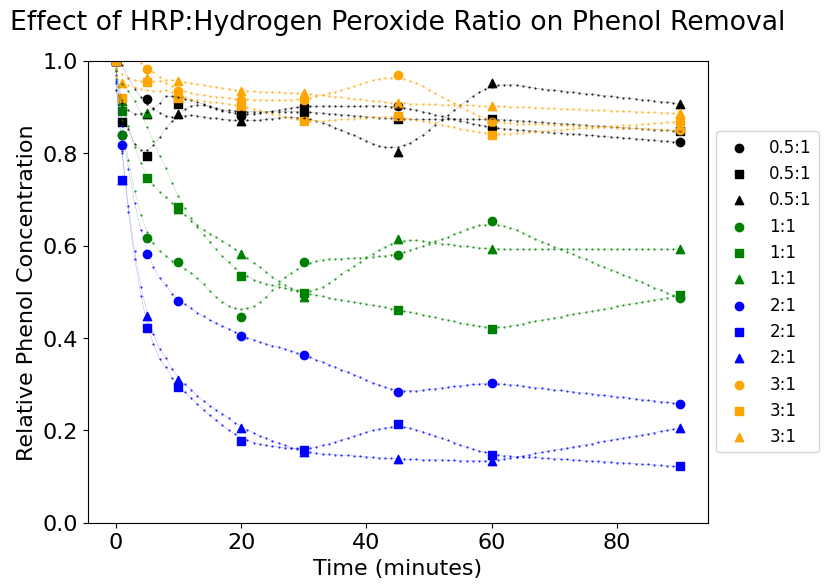

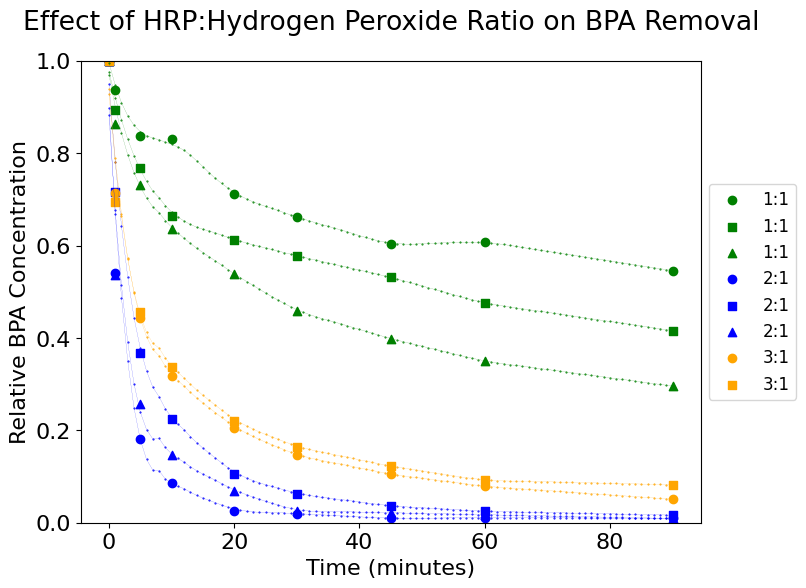

In [4]:
plot_smoothed_data(peroxide_ratio_df, smoothed_df, compound='phe')
plot_smoothed_data(peroxide_ratio_df, smoothed_df, compound='BPA')

### Scale concentrations so max conc is not 1
Phenol was used at an initial concentration of 100 mM <br>
BPA was used at an initial concentration of 100 µM

In [5]:
# scale all values in the peroxide_ratio_df and smoothed_df by 100 except for the time column
rows_to_scale = peroxide_ratio_df.columns[1:]
smoothed_rows_to_scale = smoothed_df.columns[1:]

peroxide_ratio_df[rows_to_scale] = peroxide_ratio_df[rows_to_scale] * 100
smoothed_df[smoothed_rows_to_scale] = smoothed_df[smoothed_rows_to_scale] * 100

peroxide_ratio_df

,time,0.5:1 phe 1,0.5:1 phe 2,0.5:1 phe 3,1:1 phe 1,1:1 phe 2,1:1 phe 3,2:1 phe 1,2:1 phe 2,2:1 phe 3,...,3:1 phe 2,3:1 phe 3,1:1 BPA 1,1:1 BPA 2,1:1 BPA 3,2:1 BPA 1,2:1 BPA 2,2:1 BPA 3,3:1 BPA 1,3:1 BPA 2
0,0,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00,...,100.000000,100.000000,100.00,100.00,100.00,100.00,100.00,100.00,100.00,100.00
1,1,83.94,86.84,101.09,83.94,89.12,91.30,81.82,74.11,74.29,...,92.000000,95.108696,93.77,89.25,86.39,54.05,71.55,53.53,71.43,69.40
2,5,91.71,79.47,88.52,61.66,74.61,88.59,58.08,42.13,44.76,...,95.428571,96.195652,83.70,76.79,73.11,18.18,36.84,25.61,44.33,45.57
3,10,92.23,90.53,88.52,56.48,68.39,67.93,47.98,29.44,30.95,...,92.000000,95.652174,82.97,66.36,63.53,8.60,22.53,14.68,31.86,33.66
4,20,88.08,88.95,86.89,44.56,53.37,58.15,40.40,17.77,20.48,...,90.285714,93.478261,71.06,61.21,53.78,2.64,10.53,6.91,20.53,22.06
5,30,90.16,88.95,87.98,56.48,49.74,48.91,36.36,15.74,15.24,...,86.857143,92.934783,66.12,57.79,45.88,1.98,6.25,2.59,14.61,16.43
6,45,90.16,87.37,80.33,58.03,46.11,61.41,28.28,21.32,13.81,...,88.000000,90.760870,60.26,53.12,39.83,0.94,3.62,2.16,10.51,12.24
7,60,85.49,87.37,95.08,65.29,41.97,59.24,30.30,14.72,13.33,...,84.000000,90.217391,60.81,47.51,34.96,1.09,2.47,1.73,7.88,9.18
8,90,82.38,84.74,90.71,48.70,49.22,59.24,25.76,12.18,20.48,...,86.857143,88.586956,54.58,41.59,29.58,0.96,1.64,0.92,5.09,8.21


### Make a dataframe of enzymatic rates over time

In [6]:
# start the dataframe with by using the smoothed time column
rates_df = pd.DataFrame({'time': smoothed_df['time']})
rates_df_cols = smoothed_df.columns[1:]


for col in rates_df_cols:
    rate_values = savgol_filter(smoothed_df[col], window_length, poly_order, deriv=1)
    rates_df[f'{col} rate'] = -1 * rate_values

rates_df

,time,0.5:1 phe 1 smoothed rate,0.5:1 phe 2 smoothed rate,0.5:1 phe 3 smoothed rate,1:1 phe 1 smoothed rate,1:1 phe 2 smoothed rate,1:1 phe 3 smoothed rate,2:1 phe 1 smoothed rate,2:1 phe 2 smoothed rate,2:1 phe 3 smoothed rate,...,3:1 phe 2 smoothed rate,3:1 phe 3 smoothed rate,1:1 BPA 1 smoothed rate,1:1 BPA 2 smoothed rate,1:1 BPA 3 smoothed rate,2:1 BPA 1 smoothed rate,2:1 BPA 2 smoothed rate,2:1 BPA 3 smoothed rate,3:1 BPA 1 smoothed rate,3:1 BPA 2 smoothed rate
0,0,2.608966,8.007231,3.702839,11.517269,7.310989,7.499855e-01,11.871248,16.576031,15.560248,...,0.910294,1.114903,5.189933,5.892425,7.213775,24.385654,18.012598,21.834365,15.867436,15.532631
1,1,1.746149,5.811660,3.106501,9.416366,6.063088,1.393466e+00,9.939604,13.788446,13.009098,...,0.732503,0.828814,4.147767,5.155151,6.120161,19.715786,15.006849,17.630352,13.125778,12.768555
2,2,1.009213,3.887326,2.561470,7.538662,4.952492,1.936795e+00,8.193098,11.276456,10.705814,...,0.579716,0.581790,3.230008,4.475403,5.133924,15.537631,12.295893,13.877102,10.662900,10.293322
3,3,0.398158,2.234230,2.067746,5.884156,3.979199,2.379973e+00,6.631729,9.040061,8.650398,...,0.451931,0.373829,2.436655,3.853181,4.255064,11.851190,9.879730,10.574616,8.478804,8.106933
4,4,-0.087016,0.852370,1.625328,4.452849,3.143209,2.723001e+00,5.255498,7.079261,6.842849,...,0.349149,0.204932,1.767710,3.288487,3.483580,8.656463,7.758361,7.722895,6.573487,6.209387
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86,86,0.103667,0.087667,0.145667,0.553000,-0.241667,1.887221e-14,0.151333,0.084667,-0.238333,...,-0.095238,0.054348,0.207667,0.197333,0.179333,0.004333,0.027667,0.027000,0.093000,0.032333
87,87,0.103667,0.087667,0.145667,0.553000,-0.241667,1.250777e-14,0.151333,0.084667,-0.238333,...,-0.095238,0.054348,0.207667,0.197333,0.179333,0.004333,0.027667,0.027000,0.093000,0.032333
88,88,0.103667,0.087667,0.145667,0.553000,-0.241667,4.004280e-15,0.151333,0.084667,-0.238333,...,-0.095238,0.054348,0.207667,0.197333,0.179333,0.004333,0.027667,0.027000,0.093000,0.032333
89,89,0.103667,0.087667,0.145667,0.553000,-0.241667,-6.638254e-15,0.151333,0.084667,-0.238333,...,-0.095238,0.054348,0.207667,0.197333,0.179333,0.004333,0.027667,0.027000,0.093000,0.032333


### Define a function to plot enzymatic rate vs. substrate concentration

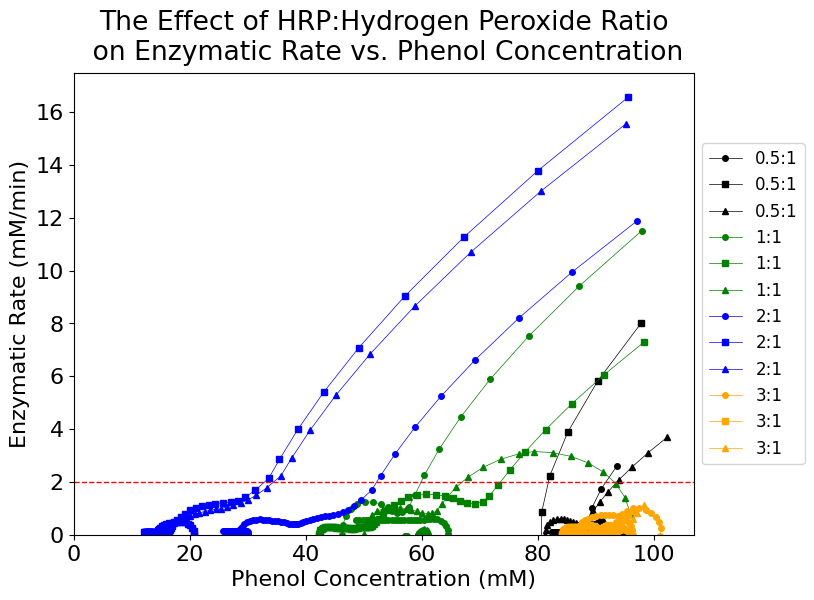

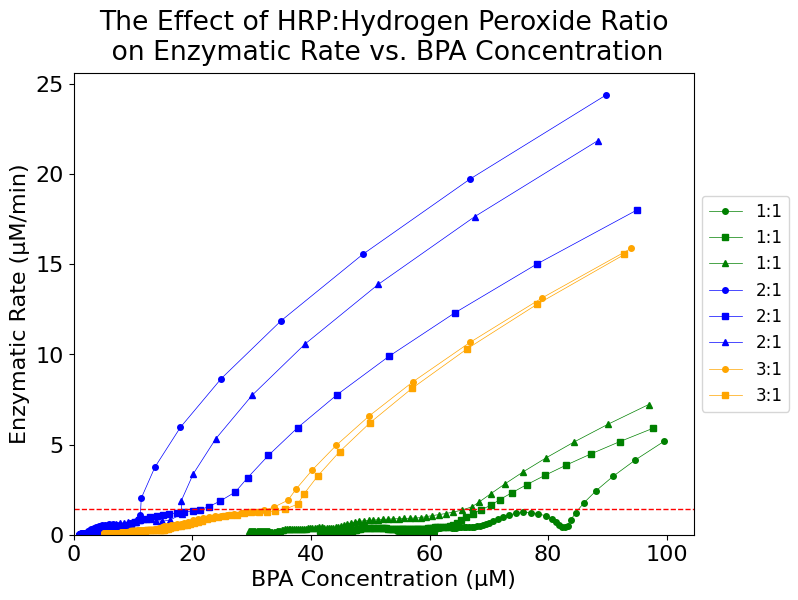

In [7]:
# define cutoff values for phenol and BPA
phenol_cutoff = 2
BPA_cutoff = 1.4

plot_rates_vs_conc(smoothed_df, rates_df, compound='phe', cutoff=phenol_cutoff)
plot_rates_vs_conc(smoothed_df, rates_df, compound='BPA', cutoff=BPA_cutoff)

### Make dataframe of fit parameters

In [8]:
# Trials to get parameters
trials_to_get_params = [
    '1:1 phe 1', 
    '1:1 phe 2',
    '2:1 phe 1',
    '2:1 phe 2',
    '2:1 phe 3',
    '1:1 BPA 1',
    '1:1 BPA 2',
    '1:1 BPA 3',
    '2:1 BPA 1',
    '2:1 BPA 2',
    '3:1 BPA 1',
    '3:1 BPA 2',
]

# Create an empty list to store the results
results = []

# Loop through trials and calculate parameters
for trial in trials_to_get_params:
    cutoff = phenol_cutoff if 'phe' in trial else BPA_cutoff
    trial_name, Vmax, Km, offset_rate, offset_conc, max_time = get_michaelis_menten_values(trial, smoothed_df, rates_df, cutoff_rate=cutoff)
    
    # Append the results as a row (list) to the results list
    results.append([trial_name, Vmax, Km, offset_rate, offset_conc, max_time])

# Convert the results list to a DataFrame
columns = ['Trial', 'Vmax', 'Km', 'Offset Rate', 'Offset Concentration', 'Max Time']
mm_param_df = pd.DataFrame(results, columns=columns)

mm_param_df

,Trial,Vmax,Km,Offset Rate,Offset Concentration,Max Time
0,1:1 phe 1,27.992993,76.571423,2.259831,60.446999,6
1,1:1 phe 2,23.603445,89.560492,2.444524,75.143784,5
2,2:1 phe 1,30.920214,98.315105,2.237629,52.899213,7
3,2:1 phe 2,40.583951,113.695584,2.133685,33.602262,8
4,2:1 phe 3,39.361913,117.419027,2.225013,35.690299,8
5,1:1 BPA 1,13.876021,41.558710,1.767710,86.036094,4
6,1:1 BPA 2,19.815804,100.060357,1.633076,70.335946,8
7,1:1 BPA 3,27.406677,114.279032,1.541771,67.116262,8
8,2:1 BPA 1,45.751191,84.986065,2.022563,11.394819,7
9,2:1 BPA 2,63.894570,207.136454,1.556612,22.777649,10


### Make clearer plot of enzymatic rate vs concentration

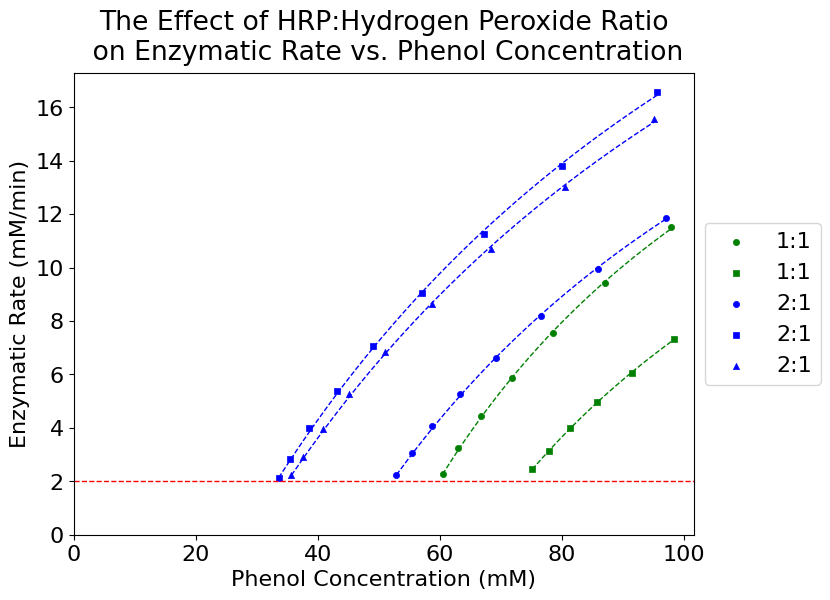

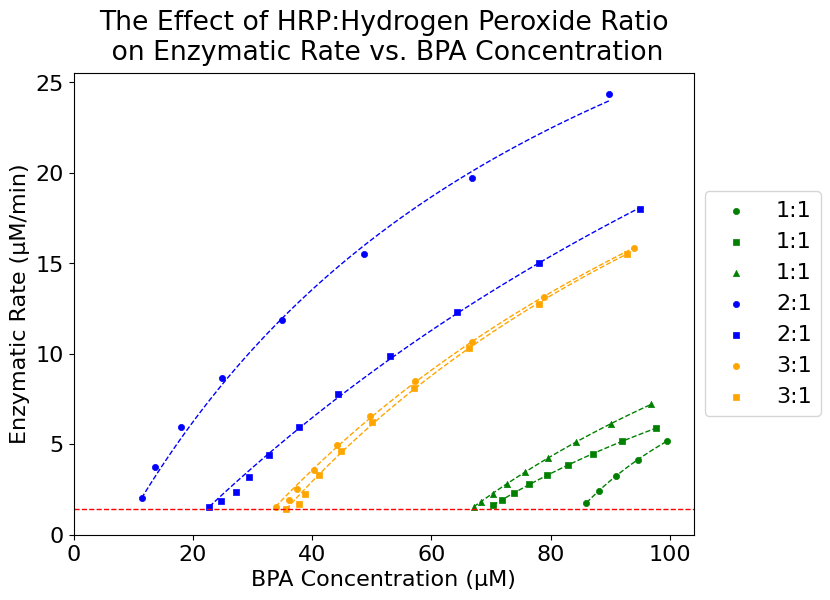

In [9]:
plot_rates_vs_conc_fit(smoothed_df, rates_df, mm_param_df, compound='phe', cutoff=phenol_cutoff)
plot_rates_vs_conc_fit(smoothed_df, rates_df, mm_param_df, compound='BPA', cutoff=BPA_cutoff)

### Define a function to create time course data from a row of parameters

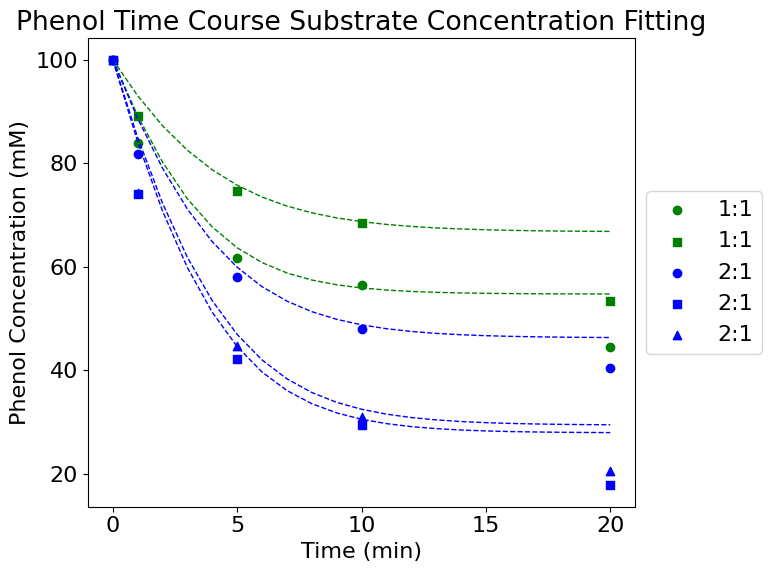

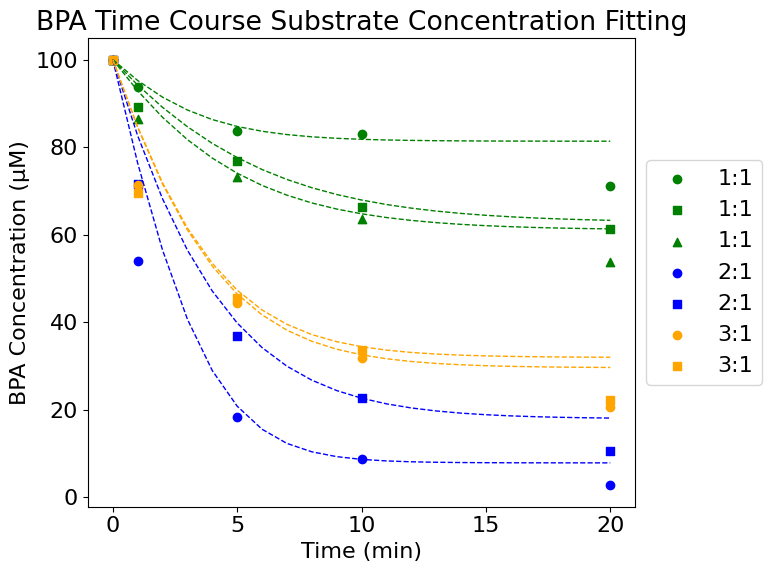

In [10]:
plot_time_courses(mm_param_df, peroxide_ratio_df, compound='phe')
plot_time_courses(mm_param_df, peroxide_ratio_df, compound='BPA')

### Print parameters

In [11]:
mm_param_df

,Trial,Vmax,Km,Offset Rate,Offset Concentration,Max Time
0,1:1 phe 1,27.992993,76.571423,2.259831,60.446999,6
1,1:1 phe 2,23.603445,89.560492,2.444524,75.143784,5
2,2:1 phe 1,30.920214,98.315105,2.237629,52.899213,7
3,2:1 phe 2,40.583951,113.695584,2.133685,33.602262,8
4,2:1 phe 3,39.361913,117.419027,2.225013,35.690299,8
5,1:1 BPA 1,13.876021,41.558710,1.767710,86.036094,4
6,1:1 BPA 2,19.815804,100.060357,1.633076,70.335946,8
7,1:1 BPA 3,27.406677,114.279032,1.541771,67.116262,8
8,2:1 BPA 1,45.751191,84.986065,2.022563,11.394819,7
9,2:1 BPA 2,63.894570,207.136454,1.556612,22.777649,10
